In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202_newer.hdf", biodiff)
data = nsx.DataSet(reader, biodiff)
expt.addData(data)

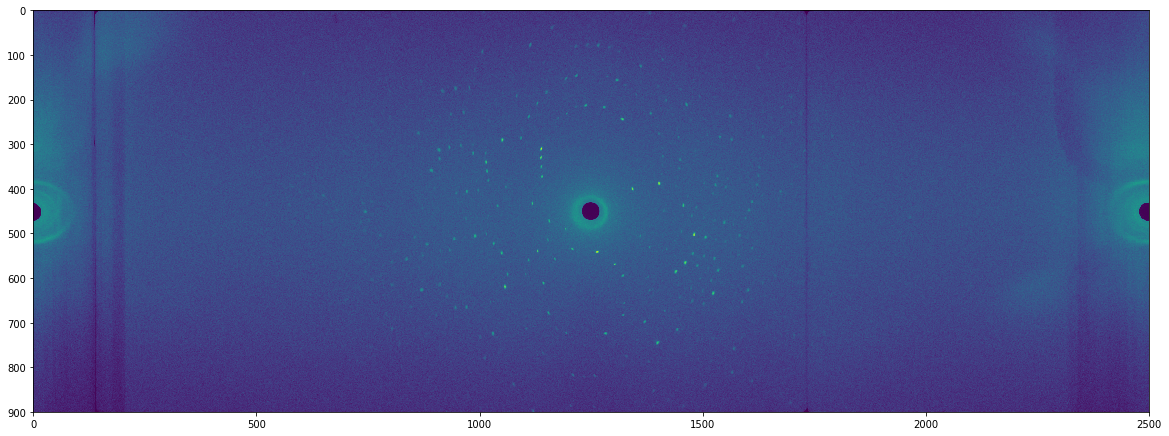

In [3]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [4]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [5]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [6]:
numors = nsx.vector_data()
numors.push_back(data)
peaks = finder.find(numors)
print(peaks.size())

indexer = nsx.AutoIndexer(nsx.ProgressHandler())

num_to_index = 0
fit_data = []

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = biodiff.getSample()
sample.addUnitCell(uc)

qs = []
hkls = []

for peak in peaks:
    if not peak.isSelected():
        continue
        
    if peak.isMasked():
        continue
        
    q = peak.getQ().rowVector()
    d = 1.0 / np.linalg.norm(q)
    
    if d < 2.0 or d > 50.0:
        continue
        
    peak.addUnitCell(uc, True)
    
    hkl = np.array([[0.,0.,0.]])    
    success = uc.getMillerIndices(peak.getQ(), hkl)
    
    if not success:
        continue
    
    qs.append(q)
    hkls.append(hkl)
    
npeaks = len(qs)

print("done indexing peaks")

print(uc.reciprocalBasis())
ch = uc.character()
print(ch.a, ch.b, ch.c)

9203
indexing 8263 peaks
done indexing peaks
[[ -9.04096713e-04   4.88911759e-03   1.74914515e-02]
 [  1.70556332e-02   1.35257750e-04   8.43763649e-04]
 [ -8.49154161e-05  -1.44352211e-02   4.03046721e-03]]
54.99224660085865 58.558201596143874 66.72192290862492


In [7]:
# create peak batches

nbatches = int(data.getNFrames() / 4.5)
#nbatches = 1
fmin = 0.0
fmax = data.getNFrames()+1
df = (fmax-fmin) / nbatches

q_batches = [ [] for i in range(nbatches) ]
hkl_batches = [ [] for i in range(nbatches) ]
frame_batches = [ [] for i in range(nbatches) ]
center_batches = [ [] for i in range(nbatches) ]
peak_batches = [ [] for i in range(nbatches) ]

for peak in peaks:
    if not peak.isSelected():
        continue
        
    if peak.isMasked():
        continue       
       
    q = peak.getQ().rowVector()
    d = 1.0 / np.linalg.norm(q)
    
    if d < 2.0 or d > 50.0:
        continue
        
    hkl = np.array([[0.,0.,0.]])    
    success = uc.getMillerIndices(peak.getQ(), hkl)
    
    if not success:
        continue
               
    frame = peak.getShape().center()[2,0]    
    batch = int(frame/df)
    #print(batch)  
    
    q_batches[batch].append(peak.getQ().rowVector())
    hkl_batches[batch].append(hkl)
    frame_batches[batch].append(frame)
    center_batches[batch].append(peak.getShape().center())
    peak_batches[batch].append(peak)
    
print(len(peaks))

9203


In [191]:
print(hkl_batches[0][20][0].dot(uc.reciprocalBasis())-q_batches[0][20][0])

[ 0.00163518 -0.00141213  0.00137052]


In [135]:
states = []

for i in range(data.getNFrames()):
    states.append(data.getInterpolatedState(i))

In [136]:
gonio = data.getDiffractometer().getSample().getGonio()
u = np.array([1.,0.,0.])
v = np.array([0.,1.,0.])
w = np.array([0.,0.,1.])

gonio.transformInPlace(u, states[10].sample)
gonio.transformInPlace(v, states[10].sample)
gonio.transformInPlace(w, states[10].sample)

print(u, v, w)


[ 0.99756405 -0.06975647  0.        ] [ 0.06975647  0.99756405  0.        ] [ 0.  0.  1.]


In [151]:
from scipy.optimize import least_squares


def encode(ki, ub):
    #return np.append(ki, ub.reshape((9)))
    #return np.array([0.,0.,0.])
    return ub.reshape((9))

def decode(x):
    #return x[:3], x[3:].reshape((3,3))
    #return x, uc.reciprocalBasis()
    return np.array([0.,0.,0.]), x.reshape((3,3))

def residual(x, qs, hkls, frames):
    n = len(qs)
    assert(n == len(hkls))
    
    ki_offset, basis = decode(x)    
    #basis = x.resize((3,3))
    fvec = np.zeros(3*n)
    
    for i in range(n):
        state = data.getInterpolatedState(frames[i])
        dq = hkls[i][0].dot(basis)-qs[i][0]-gonio.transformInverse(ki_offset, state.sample)[0]
        #print(dq)

        for j in range(3):
            fvec[3*i+j] = dq[j]
    
    return fvec

ki_offsets = []
bases = []

test = nsx.UnitCell(uc)
test.setReciprocalBasis(uc.reciprocalBasis())
ch = test.character()
print(ch.a, ch.b, ch.c)

for i in range(nbatches):
    x0 = encode([0,0,0], uc.reciprocalBasis())
    ch = uc.character()
    #print('starting character: ', ch.a, ch.b, ch.c)
    
    result = least_squares(lambda x: residual(x, q_batches[i], hkl_batches[i], frame_batches[i]), x0)  
    ki, basis = decode(result.x)
    
    batch_uc = nsx.UnitCell(uc)
    batch_uc.setReciprocalBasis(basis)
    
    ch = batch_uc.character()
    print('character', ch.a, ch.b, ch.c)#, ch.alpha, ch.beta, ch.gamma)
    
    UA = np.linalg.inv(basis)
    #print(basis)
    bases.append(basis)
    ki_offsets.append(ki)

    print('status: ', result.success, result.status)
    print('mse: ', result.fun.std())
    print('ki-offset: ', ki)
    print('-------------------------------------------------------')

54.99224660208893 58.55820159585819 66.72192288683597
character 54.85427710943638 58.49505104047258 66.689409114359
status:  True 1
mse:  0.00126346785796
ki-offset:  [ 0.  0.  0.]
-------------------------------------------------------


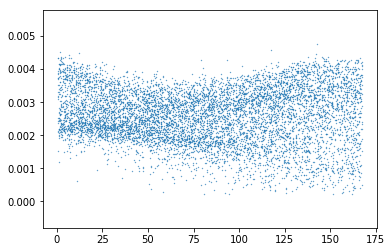

In [153]:
for i in range(nbatches):
    qs = [ np.linalg.norm(q) for q in q_batches[i] ]
    #preds = [ hkl[0]*bases[i]-ki_offsets[i] for hkl in hkl_batches[i] ]    
    #dq = [ np.linalg.norm(qs[j]-preds[j]) for j in range(len(q_batches[i]))]
    
    preds = [hkl[0].dot(uc.reciprocalBasis()) for hkl in hkl_batches[i]]
    
    frames = [ frame for frame in frame_batches[i] ]
    
    dqq = [ np.linalg.norm(preds[j]-q_batches[i][j]) / np.linalg.norm(q_batches[i][j]) for j in range(len(preds)) ]
    dq = [ np.linalg.norm(preds[j]-q_batches[i][j]) for j in range(len(preds)) ]
    #ädq = [ np.linalg.norm(preds[j]-qs[j]) for j in range(len(preds)) ]
    
    #ädhkls = [ np.linalg.norm(q) ]
    
    plt.scatter(frames, dq, s=0.1)
    plt.show()

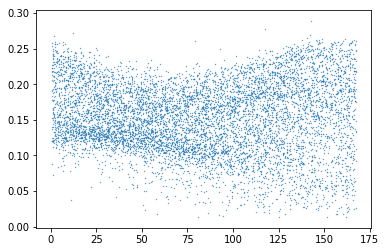

In [156]:
for i in range(nbatches):
    qs = [ np.linalg.norm(q) for q in q_batches[i] ]
    #preds = [ hkl[0]*bases[i]-ki_offsets[i] for hkl in hkl_batches[i] ]    
    #dq = [ np.linalg.norm(qs[j]-preds[j]) for j in range(len(q_batches[i]))]
    
    frames = frame_batches[i]
    
    preds = [q[0].dot(uc.basis()) for q in q_batches[i] ]    
    dhkl = [ np.linalg.norm(preds[j]-hkl_batches[i][j]) for j in range(len(q_batches[i]))]
       
    plt.scatter(frames, dhkl, s=0.1)
    plt.show()

In [151]:
for i in range(nbatches):
    duc = np.linalg.norm(bases[i]-uc.reciprocalBasis()) / np.linalg.norm(uc.reciprocalBasis())
    print(duc)

3.40420493451
4.02207078631
11.8488622508
11.9752382248
11.9725303888


In [8]:
predictor = nsx.PeakPredictor(data)

for i in range(nbatches):
    deltas = []
    frames = []
    qs = []
    ds = []
    
    for j in range(len(q_batches[i])):
        hkls = nsx.vectorRowVector3d()
        hkls.push_back(hkl_batches[i][j])
        predicted_peak = predictor.predictPeaks(hkls, bases[i])
    
        for peak in predicted_peak:
           
            obs = center_batches[i][j]
            pred = peak.getShape().center()
            #print(obs-pred)
            
            delta = np.linalg.norm(obs-pred)
            
            
            # something clearly very wrong...
            if (delta > 10.0):
                peak_batches[i][j].setSelected(False)
                continue
                
            deltas.append(delta)
            
            frames.append(frame_batches[i][j])
            q = np.linalg.norm(peak.getQ().rowVector())
            qs.append(q)
            ds.append(1.0/q)
            
            
    plt.scatter(frames, deltas, s=0.1)
    plt.show()
            

NameError: name 'bases' is not defined

In [9]:
source = data.getDiffractometer().getSource()
sample = data.getDiffractometer().getSample()

source_gonio = source.getGonio()
sample_gonio = sample.getGonio()

def print_physical_axes(gonio):
    for i in range(gonio.getNAxes()):
        ax = gonio.getAxis(i)
    
        if not ax.isPhysical():
            continue
        
        print(i, ax.getLabel())
    
print_physical_axes(source_gonio)
print_physical_axes(sample_gonio)


0 om-mono
1 chi-mono
2 phi-mono
3 x-mono
4 y-mono
0 omega
1 chi
2 phi
3 x-offset
4 y-offset
5 z-offset


In [21]:
peak_list = nsx.PeakList()

for peak in peaks:
    if not peak.isSelected():
        continue
        
    #q = peak.getQ()
    #hkl = uc.getIntegerMillerIndices(q)
    
    #error = np.linalg.norm(q.rowVector()-hkl.dot(uc.reciprocalBasis())) / np.linalg.norm(q.rowVector())
    
    #if error > 0.02:
    #    peak.setSelected(False)
     #   continue
        
    peak_list.push_back(peak)
    
print('refining for ', peak_list.size(), " peaks")

refiner = nsx.Refiner(uc, peak_list, nbatches)
refiner.refineB()

for i in range(6):
    refiner.refineSampleState(data.getInstrumentStates(), i)
for i in range(3):
    refiner.refineSourceState(data.getInstrumentStates(), i)
    
result = refiner.refine(200)
print(result)

refining for  6626  peaks
True


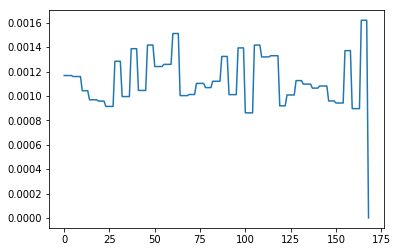

In [48]:
states = data.getInstrumentStates()

ax = 5

sample_states = [ state.sample._offsets[ax] for state in states ]
#source_states = [ state.source._offsets[ax] for state in states ]

plt.plot(sample_states)
plt.show()

#plt.plot(source_states)
#plt.show()

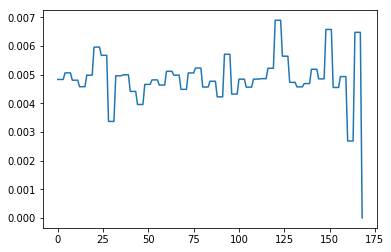

In [37]:
ki = np.array([[0.,1.,0.]]).transpose()
dk = [ np.linalg.norm(source_gonio.transformInverse(ki, state.source) - ki) for state in states ]

plt.plot(dk)
plt.show()

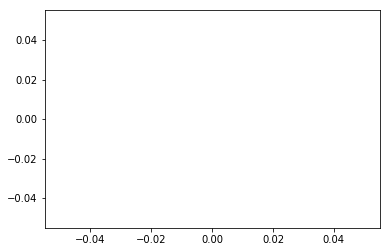

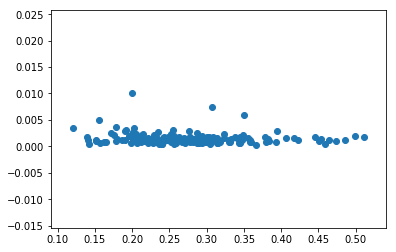

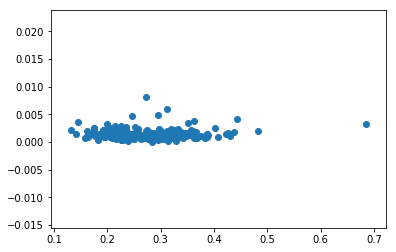

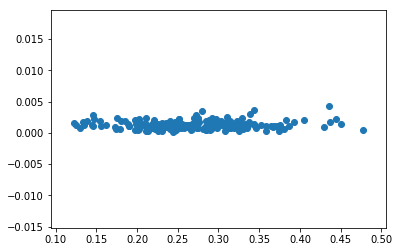

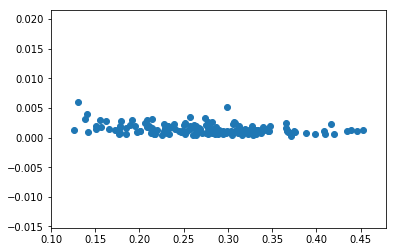

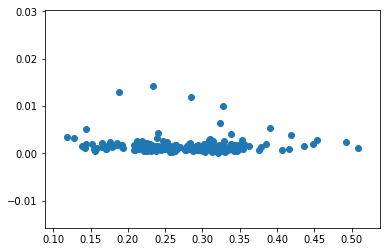

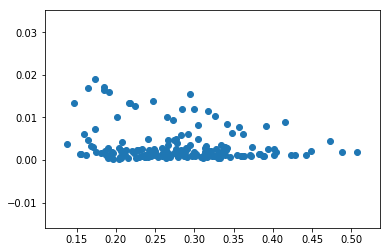

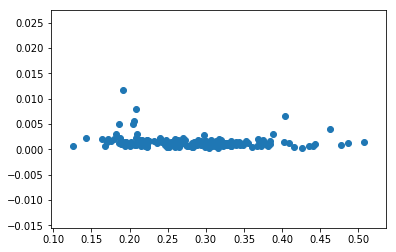

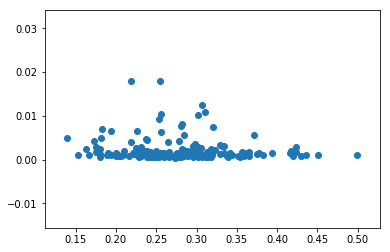

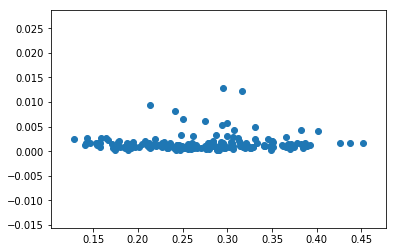

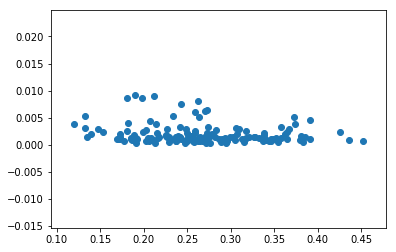

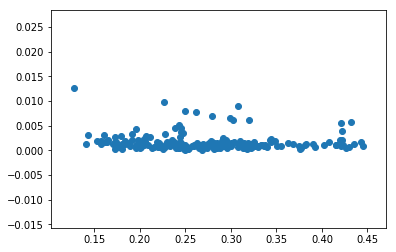

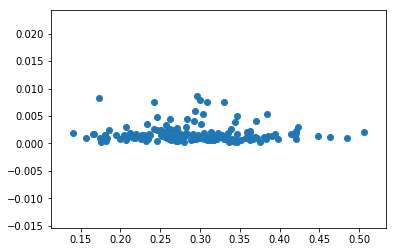

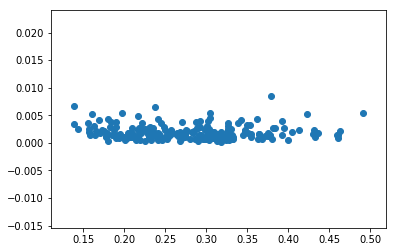

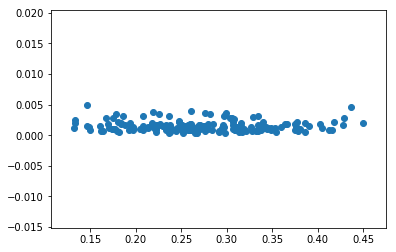

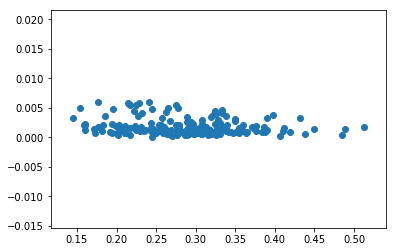

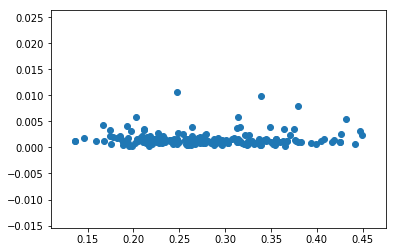

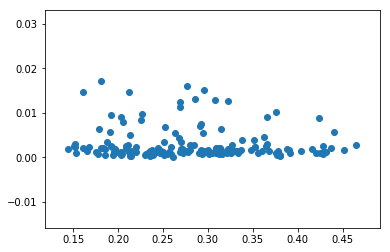

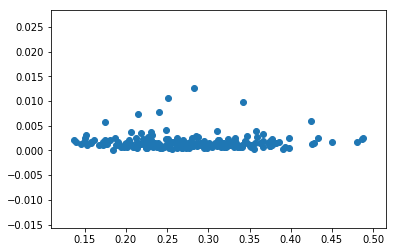

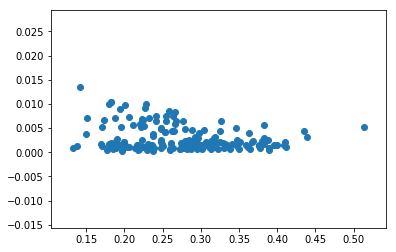

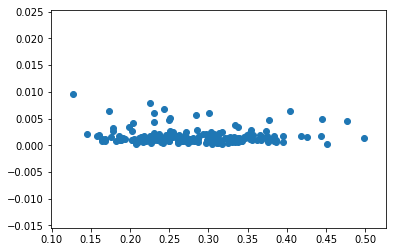

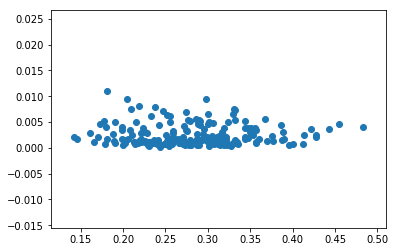

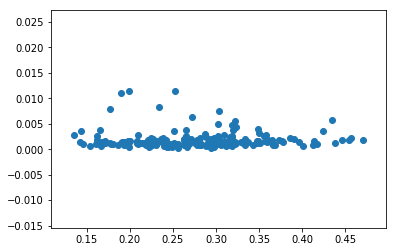

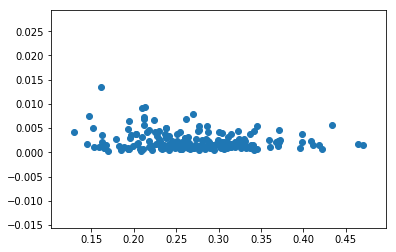

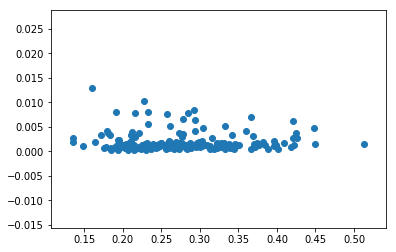

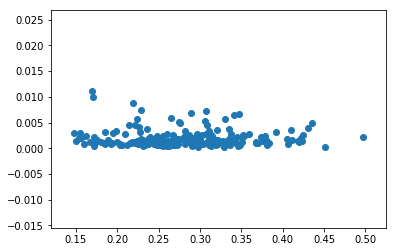

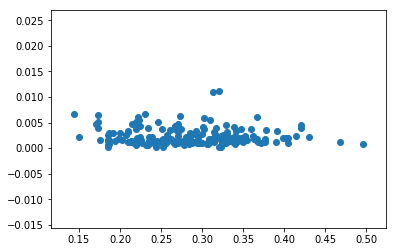

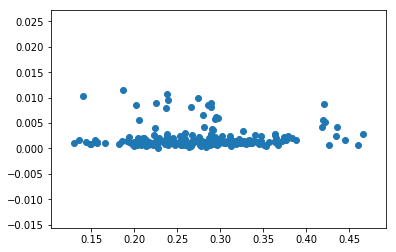

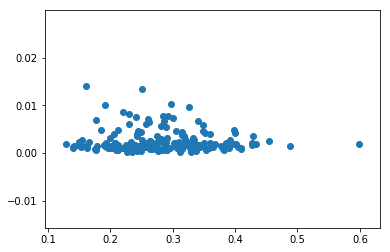

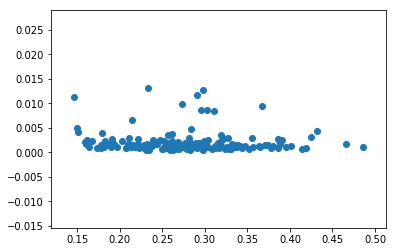

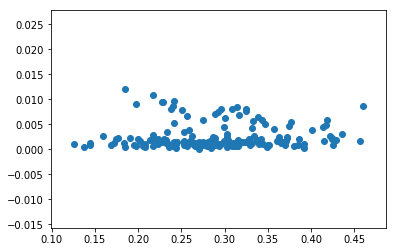

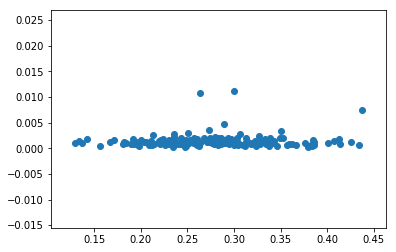

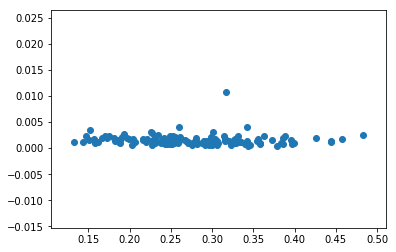

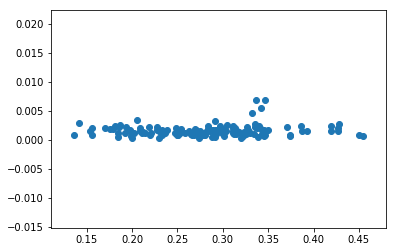

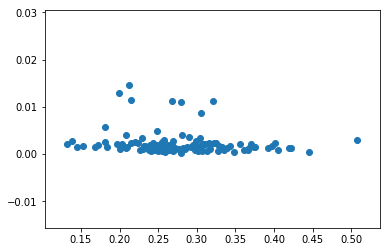

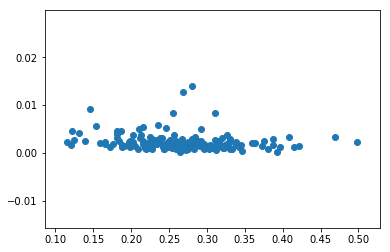

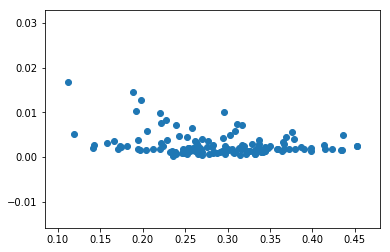

In [23]:
batches = refiner.batches()
peak_batches = [ [] for batch in batches ]

batch_id = 0

for batch in batches:
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        frame = peak.getShape().center()[2,0]
        
        if batch.contains(frame):
            peak_batches[batch_id].append(peak)
            
    batch_id += 1

for i in range(len(batches)):
    batch = batches[i]
    basis = batch.cell().reciprocalBasis()
    
    hkls = []
    frames = []
    qs = []
    ds = []
    pxs = []
    dqs = []
    
    for peak in peak_batches[i]:
        q = peak.getQ()
        hkl = batch.cell().getIntegerMillerIndices(q)
        center = peak.getShape().center()
        
        qs.append(np.linalg.norm(q.rowVector()))
        hkls.append(hkl)
        
        dq = q.rowVector() - hkl.dot(basis)
        dqs.append(np.linalg.norm(dq))
        
        frames.append(center[2,0])
        
        if np.linalg.norm(dq)/np.linalg.norm(q.rowVector()) > 0.02:
            peak.setSelected(False)
        
    plt.scatter(qs, np.array(dqs) / np.array(qs))
    plt.show()

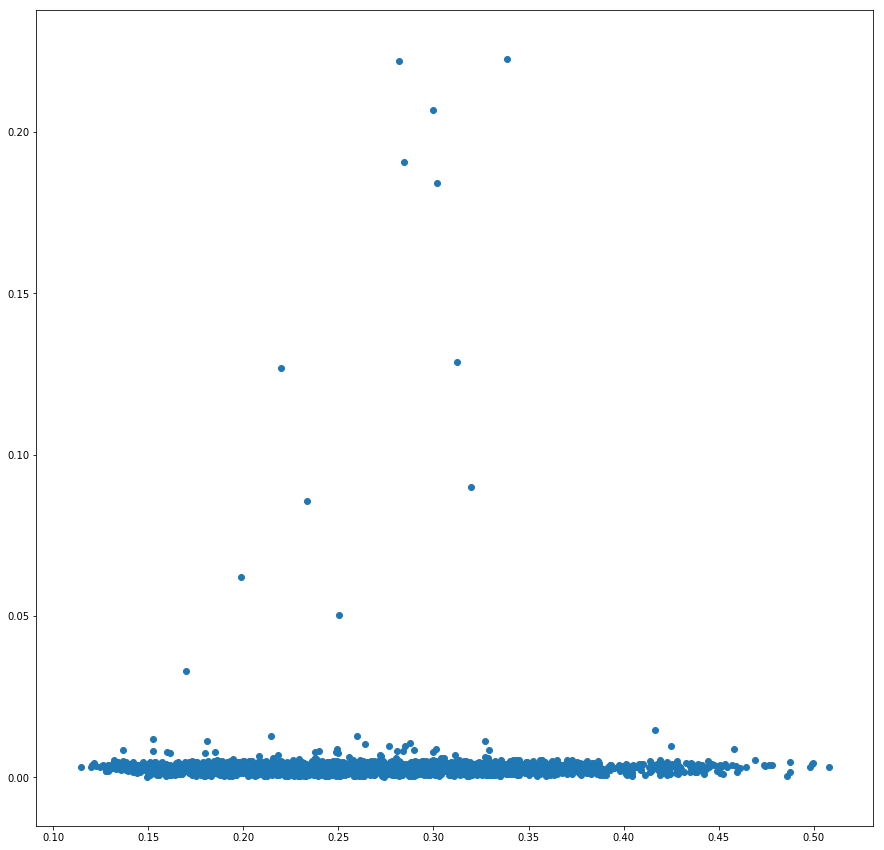

In [26]:
predictor = nsx.PeakPredictor(data)

deltas = []
frames = []
qs = []
ds = []
dqs = []

for batch in batches:
    
    for peak in batch.peaks():
        hkls = nsx.vectorRowVector3d()
        hkls.push_back(np.array(batch.cell().getIntegerMillerIndices(peak.getQ()), dtype=float))
        predicted_peak = predictor.predictPeaks(hkls, batch.cell().reciprocalBasis())
    
        if (len(predicted_peak) == 0):
            peak.setSelected(False)
    
        for pred_peak in predicted_peak:
           
            obs = peak.getShape().center()
            pred = pred_peak.getShape().center()
            #print(obs-pred)
            
            delta = np.linalg.norm(obs-pred)
                        
            # something clearly very wrong...
            if (delta > 7.0):
                peak.setSelected(False)
                continue
                
            deltas.append(delta)
            
            frames.append(obs[2,0])
            q = np.linalg.norm(peak.getQ().rowVector())
            qs.append(q)
            ds.append(1.0/q)
            dqs.append(np.linalg.norm(pred_peak.getQ().rowVector()-peak.getQ().rowVector()))
            
fig = plt.figure(figsize=(15,15))    
plt.scatter(qs, dqs)
plt.show()